In [1]:
import sys
sys.path.append('/home/emastr/phd/')

import dolfin as dl
import mshr as ms
import numpy as np
import matplotlib.pyplot as plt
from hmm.stokes_fenics import StokesMacProb, StokesData, MacroSol, MacroSolver, StokesMicProb, MicroSolver, StokesHMMProblem, macro_to_micro, micros_to_macro
from hmm.hmm import IterativeHMMSolver
from util.basis_scaled import FourBasis, ScaleShiftedBasis
from util.mesh_tools import Box, order_connected_vertices, boundary_bbox_tree, find_intersection_on_segment

In [2]:
# Sub domain for Periodic boundary condition
class PeriodicBoundary(dl.SubDomain):
    def __init__(self, dom):
        dl.SubDomain.__init__(self)
        self.L = dom[0][1] - dom[0][0]
        self.dom = dom

    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        return bool(dl.near(x[0], self.dom[0][0]) and on_boundary)

    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
        y[0] = x[0] - self.L
        y[1] = x[1]
        

Lx, Ly = 3, 1
bbox = [[0, Lx], [0, Ly]]

Nx = 40
res = 40
Ny = int(Nx * Ly/Lx)

xDom = np.linspace(*bbox[0], Nx)
yDom = np.linspace(*bbox[1], Ny)[1:-1]


pts = [dl.Point(x, bbox[1][0]) for x in xDom]
pts = pts + [dl.Point(bbox[0][1], y) for y in yDom]
pts = pts + [dl.Point(x, bbox[1][1]) for x in xDom[::-1]]
pts = pts + [dl.Point(bbox[0][0], y) for y in yDom[::-1]]

domain = ms.Polygon(pts) # Rectangle(Point(bbox[0][0], bbox[1][0]), Point(bbox[0][1], bbox[1][1]))
mesh = ms.generate_mesh(domain, resolution=res)

In [3]:

# Define the four boundaries + circle
roof = f'near(x[1],{bbox[1][1]})'
floor = f'near(x[1], {bbox[1][0]})'

inflow = f'near(x[0], {bbox[0][0]}) && !{floor} && !{roof}'
outflow = f'near(x[0],{bbox[0][1]}) && !{floor} && !{roof}'

class Floor(dl.SubDomain):
    def inside(self, x, on_boundary):
        return bool(dl.near(x[1], bbox[1][0]) and not dl.near(x[0], bbox[0][0]) and not dl.near(x[0], bbox[0][1]))
    
N=500
freq = 50
x = np.linspace(bbox[0][0], bbox[0][1], N)
rough_boundary = np.hstack([x[:, None], -0.03 * (1.5 + np.sin(x * freq * np.pi / Lx)[:, None])])

# Define the function spaces
pb = PeriodicBoundary(bbox)
P2 = dl.VectorElement(family='P', cell=dl.triangle, degree=2)
P1 = dl.FiniteElement(family='P', cell=dl.triangle, degree=1)
P2P1 = P2 * P1
W = dl.FunctionSpace(mesh, P2P1, constrained_domain=pb)
#U = W.sub(0)#extract_sub_space([0])    
U, P = W.split()    
Ux, Uy = U.split()

# Forces
alpha = lambda x, y:  0.1 + 0.03 * np.sin(x * 2*np.pi / Lx)

# Boundary Conditions
bcu_roof = dl.DirichletBC(U, dl.Expression((f'1', '0'), degree=2), roof)
bcu_floor = dl.DirichletBC(Uy, dl.Constant(0), floor)
bcu = [bcu_roof, bcu_floor]


In [4]:
from util.logger import EventTracker
data = StokesData.from_mesh(mesh, Floor(), rough_boundary, W, bcu)

def interp(x, a):
    amean = np.mean(a)
    #basis = ScaleShiftedBasis.fromSamplesInDomain(x[:,0], a, bbox[0], ChebBasis, dim=7)
    return lambda x, y: amean #basis(np.array([x]))[0]
    #return micros_to_macro(x, a, scale=0.5)
    #return lambda x,y : basis(np.array([x]))[0]
#interp = micros_to_macro
mac = StokesMacProb(data, interp=interp, alpha0=lambda x,y: 0.1, lam=1e-5)
mac_solver = MacroSolver()

projection_op = lambda *args: macro_to_micro(*args, N=7)
mics = [StokesMicProb(data, np.array([x, 0.5]), projection_op=projection_op, width=0.1, height=0.1, corner_w=0.04, pad=0.4) for x in np.linspace(0.3, 2.8, 7)]
mic_solvers = [MicroSolver(mic , tol=1e-6) for mic in mics]

hmm_prob = StokesHMMProblem(mac, mics, data)
hmm_solver = IterativeHMMSolver(mac_solver, mic_solvers, logger=EventTracker())

Notation dx[meshfunction] is deprecated. Please use dx(subdomain_data=meshfunction) instead.
Building point search tree to accelerate distance queries.
Computed bounding box tree with 151 nodes for 76 points.


TypeError: __init__() got an unexpected keyword argument 'logger'

In [35]:
mac_guess = mac_solver.solve(mac)
mac_sol, mic_sols = hmm_solver.solve(hmm_prob, mac_guess, maxiter=20)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


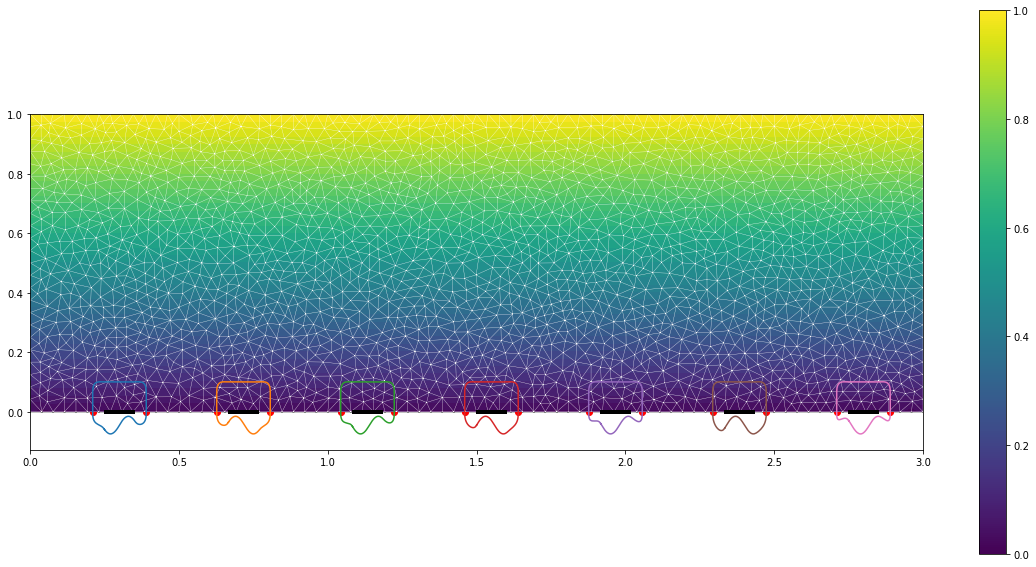

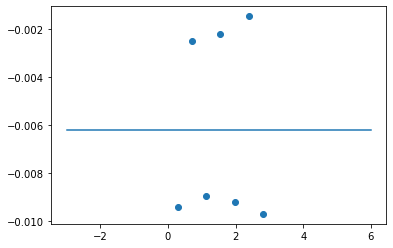

In [36]:
plt.figure(figsize=(20,10))
hmm_prob.plot(plt.gca())
dl.plot(mac_sol.u)#, vmin=0, vmax=1.)
plt.colorbar()
data.plot(plt.gca(), linewidth=0.3, color="white")

plt.figure()
#x = np.linspace(*bbox[0])
x = np.linspace(bbox[0][0]-3, bbox[0][1]+3, 200)
y = x * 0
a = np.array([mac.interp_a(xi,yi) for xi,yi in zip(x, y)])
plt.plot(x, a)
plt.scatter([s.x[0] for s in mic_sols], [s.alpha for s in mic_sols])

Solving linear variational problem.


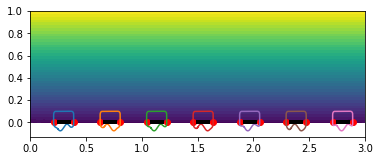

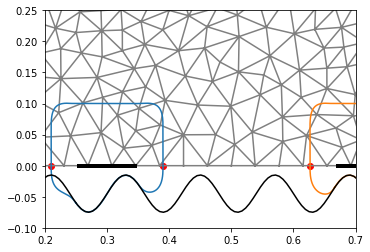

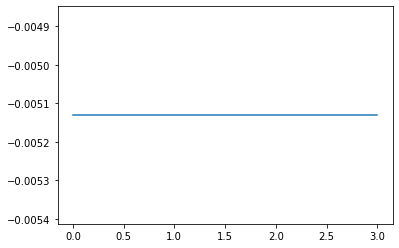

In [37]:
mac_sol = mac_solver.solve(mac)
for mic in mics:
    mic.update(mac_sol)
mic_sols = [mic_solver.solve(mic) for mic, mic_solver in zip(mics, mic_solvers)]
mac.update(mic_sols)


dl.plot(mac_sol.u)
for mic in mics:
    mic.plot(plt.gca(), npts=500)


plt.figure()
for mic in mics:
    mic.plot(plt.gca(), npts=500)
dl.plot(data.macro_mesh)
plt.plot(rough_boundary[:, 0], rough_boundary[:, 1], 'k')
plt.xlim([0.2, 0.7])
plt.ylim([-0.1, 0.25])


plt.figure()
x = np.linspace(*bbox[0])
y = x * 0
a = np.array([mac.interp_a(xi,yi) for xi,yi in zip(x, y)])
plt.plot(x, a)

(-0.3, 0.3)

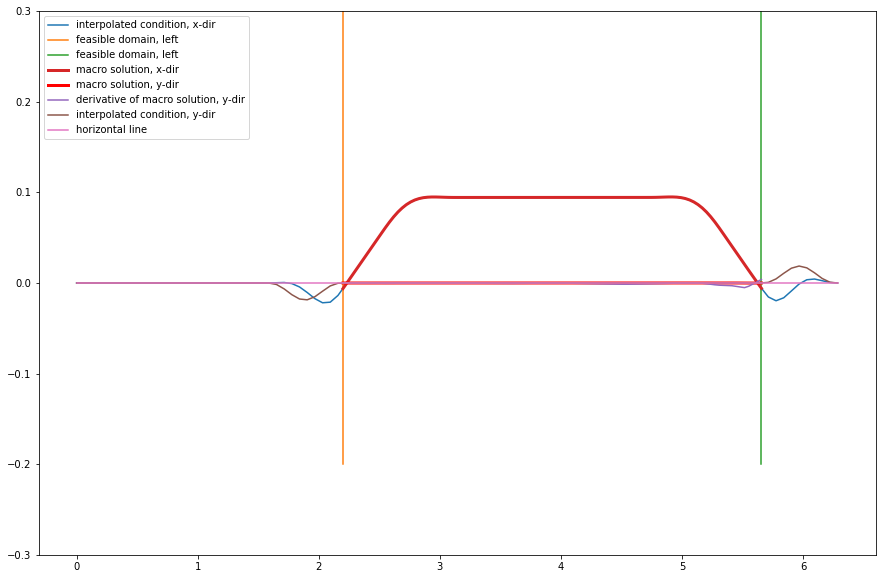

In [38]:
mic = mics[0]
plt.figure(figsize=(15, 10))
mic.update(mac_sol)
t = np.linspace(0, 2*np.pi, 100)
g = mic.condition(t)
t0 = mic.feasible_domain

ts = np.linspace(t0[0], t0[1], 100)
z = mic.geom.eval_param(t=ts)
pts = [dl.Point(zv.real, zv.imag) for zv in z]
u = np.array([mac_sol.u(p) for p in pts])
v = np.array([mac_sol.v(p) for p in pts])
gu = np.array([mac_sol.grad_u(p)[0] for p in pts])
gv = np.array([mac_sol.grad_v(p)[0] for p in pts])

plt.plot(t, g.real, label='interpolated condition, x-dir')
plt.plot([t0, t0], [-0.2, 1], label='feasible domain, left')
plt.plot(ts, u, linewidth=3, label='macro solution, x-dir')
plt.plot(ts, v, color='r', linewidth=3, label='macro solution, y-dir')
plt.plot(ts, gu, label='derivative of macro solution, y-dir')
plt.plot(t, g.imag, label='interpolated condition, y-dir')
plt.plot(t, 0*t, label='horizontal line')
plt.legend()
plt.ylim([-0.3, 0.3])